In [235]:
import glob
import os
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
from IPython.display import Image

# print(bmps)

Using matplotlib backend: nbAgg
['../data/20170421-RangeFinderSetupTest\\0.0.bmp', '../data/20170421-RangeFinderSetupTest\\0.5.bmp', '../data/20170421-RangeFinderSetupTest\\1.0.bmp', '../data/20170421-RangeFinderSetupTest\\1.5.bmp', '../data/20170421-RangeFinderSetupTest\\2.0.bmp', '../data/20170421-RangeFinderSetupTest\\2.5.bmp', '../data/20170421-RangeFinderSetupTest\\3.0.bmp', '../data/20170421-RangeFinderSetupTest\\3.5.bmp', '../data/20170421-RangeFinderSetupTest\\4.0.bmp', '../data/20170421-RangeFinderSetupTest\\4.5.bmp', '../data/20170421-RangeFinderSetupTest\\5.0.bmp', '../data/20170421-RangeFinderSetupTest\\5.5.bmp', '../data/20170421-RangeFinderSetupTest\\6.0.bmp', '../data/20170421-RangeFinderSetupTest\\6.5.bmp', '../data/20170421-RangeFinderSetupTest\\7.0.bmp', '../data/20170421-RangeFinderSetupTest\\7.5.bmp', '../data/20170421-RangeFinderSetupTest\\8.0.bmp']


In [312]:
folder = '../data/20170421-RangeFinderSetupTest'
bmps = glob.glob(os.path.join(folder,'*.bmp'))

p = []
d = []
pix_ids = np.arange(750)
for i, img_file in enumerate(bmps):
    img = misc.imread(img_file)
    psf = img.mean(0)[750:]
    psf[psf<50] = 0
    if i == 0:
        pos = psf.argmax()
        img_stack = img
    else: 
        pos = (psf * pix_ids).sum()/psf.sum()
        img_stack = np.vstack((img, img_stack))
    p.append(pos*0.0055)
    d.append(float(img_file[-7:-4]))
  

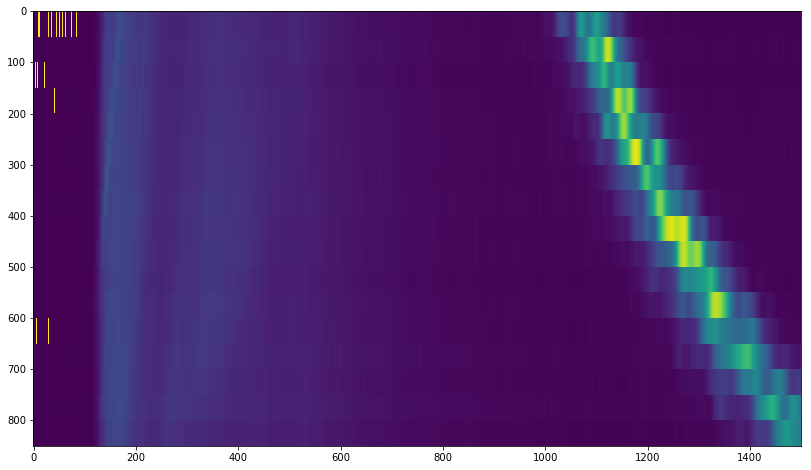

In [297]:
%matplotlib inline 
plt.figure(figsize=(15, 8))
plt.imshow(img_stack)

    Equation to calculate the depth of the measured surface:
$$d = \frac{b \times f}{p}$$

[  2.14515392  14.37801264]


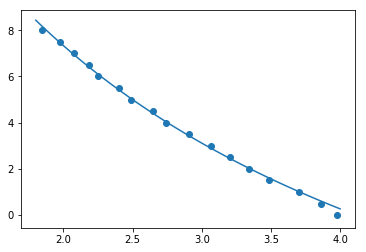

In [331]:
from scipy.optimize import curve_fit
def p2d_bf(p, b, f, p0, d0):
    return b * f /(p+p0) - d0

def p2d_b0(p, p0, d0):
    b = 10
    f = 9
    return b * f /(p+p0) - d0

p2d = p2d_b0
popt, pcov = curve_fit(p2d, p[1:], d[1:])
print(popt)

xp = np.linspace(1.8, 4, 100)
yd = p2d(xp, *popt)
plt.plot(xp, yd)
plt.scatter(p, d)

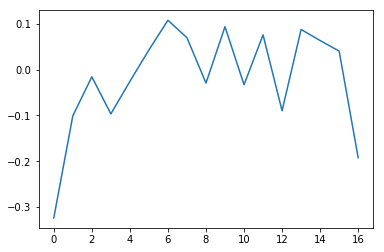

In [332]:
errors = d - p2d(p, *popt)
plt.plot(errors)

As shown above, with only 2mm range on the sensor, we were able to cover 8mm depth range with ~0.1mm resolution. 
it is noticeable that we will have a slight singal attenuation when surface goes deeper, the dependency can be formulated as:

$$Total Signal: E_t = \frac{\cos^2 a \times \sin^2 a}{(b + f \times \tan a)}$$
$$Average Signal Per Pix: E_p = \frac{\cos^3 a \times \sin^2 a}{(b + f \times \tan a)}$$

here a0 = 28.2 and  if we use the design values below, we have about 41% drop of signal from cloest surface @10mm to furthest surface @25mm
![Design](../figures/RangeFinderDesignDimensions.png) 

also, the laser beam size should be small to guarantee both vertical/depth and lateral resolution, beam size ~1mm is desirable. The spot size on the sensor is determined by the slit width and beam size as below
![Design](../figures/PinholeImgSize.png) 


# lens optical axis angle tolerance:
Assume
- beamsize: $\phi$
- furthest surface to  lens: dmax
- sensor height: h

then the angle tolerance between the lens and laser:
$$\arctan(\frac{\frac{f \times \phi}{dmax} - h}{f})$$
if we use a lens with beam size of 2mm, for furthest measuremnt, the maginfication on sensor is about 1/3, or the beam size will be, 0.6mm, the tolerance of angle is about 4 degrees
